In [6]:
import pandas as pd
import os
import shutil

CWD = os.getcwd()

DATA_DIR = f"{CWD}/data"
TRAIN_DIR = f"{DATA_DIR}/Train"
VAL_DIR = f"{DATA_DIR}/Val"

In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
import keras.preprocessing
import utils
from PIL import Image

## Loading and processing data

In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator()
test_dataset = keras.preprocessing.image.ImageDataGenerator()

In [9]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 288 images belonging to 2 classes.


In [10]:
val_generator = test_dataset.flow_from_directory(
    VAL_DIR,
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"
)

Found 60 images belonging to 2 classes.


## Baseline CNN

<a href="https://ibb.co/Pjcx7RL"><img src="https://i.ibb.co/MScnYbv/Screenshot-2023-05-04-at-21-58-30.png" alt="Screenshot-2023-05-04-at-21-58-30" border="0"></a>

In [202]:
baseline_model = Sequential([
    Conv2D(4, (3,3)),
    Conv2D(10, (7,7)),
    Conv2D(10, (7,7)),
    Conv2D(2, (1,1)),
    Flatten(),
    Dense(10),
    Dense(2, activation="softmax")
])

baseline_model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"])

In [124]:
baseline_hist = baseline_model.fit(
    train_generator,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = 2
)

Epoch 1/10


2023-04-28 14:50:15.628008: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8/8 [==============================] - 7s 773ms/step - loss: 2572.1011 - accuracy: 0.4609 - val_loss: 1675.6731 - val_accuracy: 0.5000
Epoch 2/10
8/8 [==============================] - 6s 848ms/step - loss: 405.3784 - accuracy: 0.6484 - val_loss: 33.2496 - val_accuracy: 0.9333
Epoch 3/10
8/8 [==============================] - 6s 816ms/step - loss: 41.1713 - accuracy: 0.8945 - val_loss: 56.1770 - val_accuracy: 0.9167
Epoch 4/10
8/8 [==============================] - 6s 746ms/step - loss: 35.5834 - accuracy: 0.9414 - val_loss: 49.2465 - val_accuracy: 0.9167
Epoch 5/10
8/8 [==============================] - 9s 1s/step - loss: 47.8488 - accuracy: 0.9180 - val_loss: 114.9064 - val_accuracy: 0.8667
Epoch 6/10
8/8 [==============================] - 14s 2s/step - loss: 37.7344 - accuracy: 0.9258 - val_loss: 18.8588 - val_accuracy: 0.9500
Epoch 7/10
8/8 [==============================] - 11s 1s/step - loss: 36.9018 - accuracy: 0.9297 - val_loss: 100.5619 - val_accuracy: 0.7667
Epoch 8/10
8/8 [=

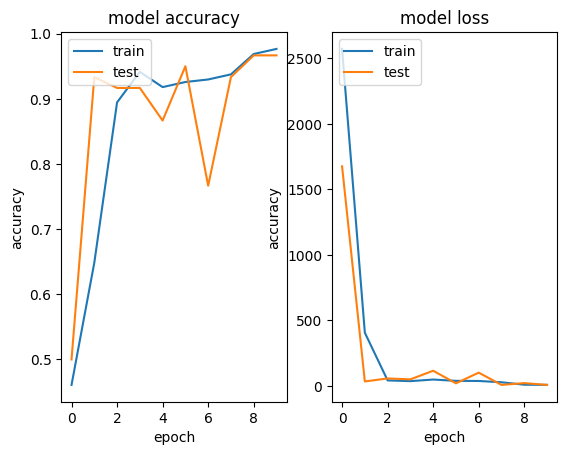

Basline model accuracy (val): 0.9765625


In [125]:
utils.visualize_history(baseline_hist, name="baseline")

## Prepare topological features

According to the paper we calculate 0-dimensional persistence diagram of the lower-star filtartion.

In [158]:
import numpy as np
from ripser import Rips
import ripser
from persim import plot_diagrams
from gtda.diagrams import BettiCurve
import math

rips = Rips()

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [154]:
train_generator.samples

288

In [187]:
batch_images_train, batch_labels_train = [], []

for _ in range(math.ceil(train_generator.samples / train_generator.batch_size)):
    data, label = train_generator.next()
    batch_images_train.extend(data)
    batch_labels_train.extend(data)

batch_images_test, batch_labels_test = [], []

for _ in range(math.ceil(val_generator.samples / val_generator.batch_size)):
    data, label = val_generator.next()
    batch_images_test.extend(data)
    batch_labels_test.extend(data)

batch_images_train = np.array(batch_images_train)
# batch_labels_train = np.array(batch_labels_train)

batch_images_test = np.array(batch_images_test)
# batch_labels_test = np.array(batch_labels_test)

In [189]:
batch_labels_test

[array([[[57.],
         [61.],
         [69.],
         ...,
         [76.],
         [79.],
         [60.]],
 
        [[55.],
         [64.],
         [63.],
         ...,
         [79.],
         [75.],
         [59.]],
 
        [[52.],
         [57.],
         [65.],
         ...,
         [78.],
         [73.],
         [57.]],
 
        ...,
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ...,
         [ 0.],
         [ 0.],
         [ 0.]]], dtype=float32),
 array([[[178.],
         [180.],
         [180.],
         ...,
         [ 59.],
         [ 59.],
         [ 66.]],
 
        [[178.],
         [179.],
         [179.],
         ...,
         [ 65.],
         [ 65.],
         [ 64.]],
 
        [[178.],
         [179.],
         [183.],
   

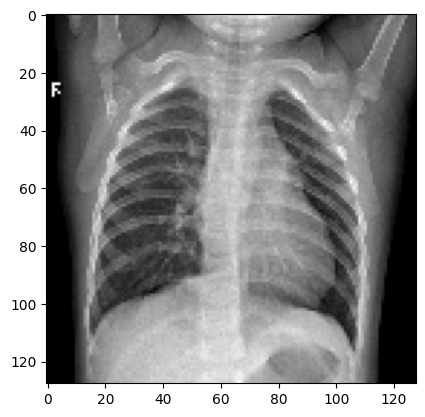

In [165]:
# The flow_from_directory method with color_mode='grayscale' returns a 3D array
vectorized_images = np.array(
    batch_images_train[:len(batch_images_train)]
    ).reshape(-1, 128, 128) / 255.0

plt.imshow(vectorized_images[0], cmap='gray')
plt.show()

In [174]:
vectorized_images.shape

(288, 128, 128)

In [175]:
dgms = [ripser.lower_star_img(-img) for img in vectorized_images]

Preview of an example persistence diagram.

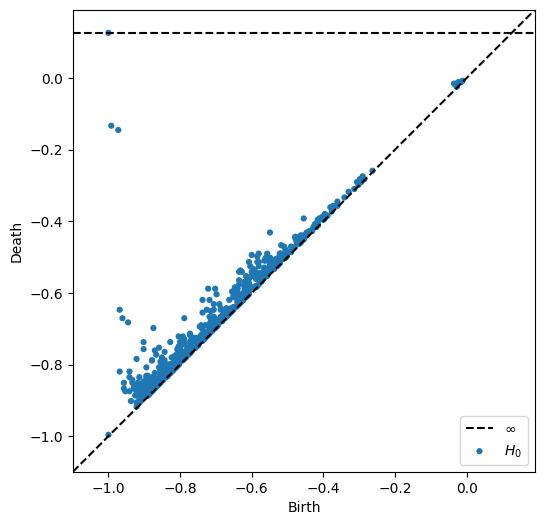

In [176]:
plt.figure(figsize=(6, 6))
plot_diagrams(dgms[11], lifetime=False)
plt.show()

In [177]:
# change a format to fit into package that calculates betti-curve

dgms_processed = [
    [[(pt[0], pt[1], 0) for pt in dgm[:-1]]]
    for dgm in dgms
]

In [179]:
bc = BettiCurve()

betti_curves = np.array([
    bc.fit_transform(X = dgm)[0][0]
    for dgm in dgms_processed
])

betti_curves.shape # random example betti-curve

(288, 100)

Above code after development was transformed into a single function to easily use it later on.

In [180]:
X_train_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_train)
y_train_1st_tda_net = batch_labels_train

X_test_1st_tda_net = utils.transform_images_to_betti_curves(batch_images_test)
y_test_1st_tda_net = batch_labels_test

In [182]:
y_train_1st_tda_net.shape

(288, 128, 128, 1)

## 1st TDA-Net model

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6XvP1t5/Screenshot-2023-05-04-at-20-46-07.png" alt="Screenshot-2023-05-04-at-20-46-07" border="0"></a>

In [172]:
first_tda_net_model = Sequential([
    Dense(300),
    Dense(600),
    Dense(200),
    Dense(200),
    Dense(2, activation="softmax")
])

first_tda_net_model.compile(
    loss = keras.losses.categorical_crossentropy,
    optimizer = "adam",
    metrics = ["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

first_tda_net_hist = first_tda_net_model.fit(
    x = X_train_1st_tda_net,
    y = y_train_1st_tda_net,
    steps_per_epoch = 8,
    epochs = 10,
    validation_data = (
        X_test_1st_tda_net,
        y_test_1st_tda_net
    ),
    validation_steps = 2,
    verbose = 0
    )

ValueError: in user code:

    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/Users/dominikilnicki/Documents/07_semestr_5/Inteligencja obliczeniowa/projekt02/venv/lib/python3.9/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (36, 128, 128, 1) and (36, 2) are incompatible


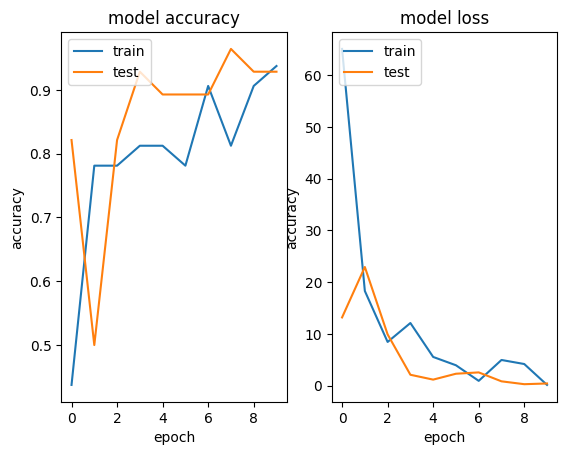

first_tda_net model accuracy (val): 0.9375


In [127]:
utils.visualize_history(first_tda_net_hist, name="first_tda_net")

In [129]:
first_tda_net_hist.history['recall'][-1]

KeyError: 'recall'

In [82]:
first_tda_net_model.predict(X_test_1st_tda_net)

1/1 [==============================] - 0s 15ms/step


array([[1.00000000e+00, 2.48685258e-22],
       [1.00000000e+00, 7.15211862e-21],
       [1.00000000e+00, 0.00000000e+00],
       [9.92085516e-01, 7.91449938e-03],
       [0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.03548617e-29, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [8.96320879e-01, 1.03679061e-01],
       [1.13490727e-17, 1.00000000e+00],
       [7.49883088e-27, 1.00000000e+00],
       [1.00000000e+00, 6.04749706e-28],
       [1.00000000e+00, 9.63785678e-20],
       [0.00000000e+00, 1.00000000e+00],
       [1.66114583e-16, 1.00000000e+00],
       [6.34180514e-21, 1.00000000e+00],
       [4.32736524e-05, 9.99956727e-01],
       [2.09124060e-03, 9.97908831e-01],
       [1.00000000e+00, 9.22204411e-14],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 1.00000000e+00],
       [9.99987006e-01, 1.29636865e-05],
       [1.00000000e+00, 1.09547374e-20],
       [1.000000